In [1]:
import pandas as pd
from pyarrow import parquet as pq
import s3fs
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [2]:
%%time
df = pd.read_csv('PRW_all.csv')


CPU times: user 28.7 s, sys: 2.76 s, total: 31.4 s
Wall time: 32.8 s


In [3]:
df['ProjectName'] = 'postrock'
df = df.rename(columns = {'TimeStampUTCSystem':'TimeStamp'})
df = df.rename(columns = {'Name':'DeviceName'})
df = df.rename(columns = {'WTG_ID':'DeviceIDI'})
df['TimeStamp'] = pd.to_datetime(df['TimeStamp'], infer_datetime_format=True)

In [5]:
g = df.groupby(pd.Grouper(key='TimeStamp', freq='W'))
# groups to a list of dataframes with list comprehension
dfs_w = [group for _,group in g]

In [33]:
from operational_analysis.toolkits import power_curve
from operational_analysis.toolkits import filters

In [44]:
def plot_flagged_pc(ws, p, flag_bool, alpha):
    plt.scatter(ws, p, s = 1, alpha = alpha)
    plt.scatter(ws[flag_bool], p[flag_bool], s = 1, c = 'red')
    plt.xlabel('Wind speed (m/s)')
    plt.ylabel('Power (kW)')
    plt.show()

## Preprocessing

In [66]:
one_week = dfs_w[51]  # take the last week.

# get power and windspeed
windspeed = one_week.WindSpeed_Avg
power_kw = one_week.ActivePower

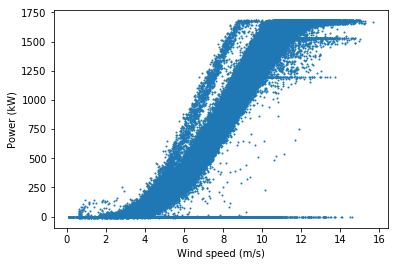

In [67]:
plot_flagged_pc(windspeed, power_kw, np.repeat('True', df.shape[0]), 1)
one_week = one_week[one_week.Seconds_In_Operation > 0]  

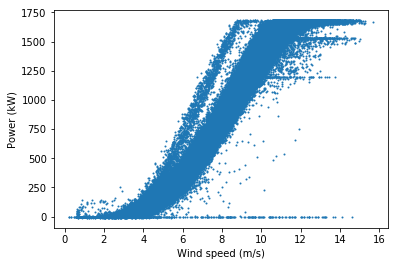

In [68]:
# Filter by operating conditions.
# get power and windspeed
windspeed = one_week.WindSpeed_Avg
power_kw = one_week.ActivePower
plot_flagged_pc(windspeed, power_kw, np.repeat('True', df.shape[0]), 1)

Series([], Name: WindSpeed_Avg, dtype: float64)


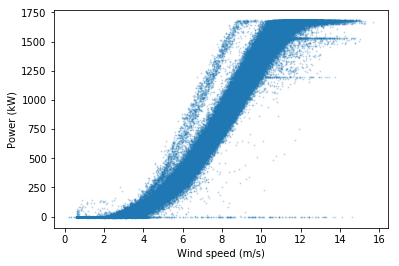

In [69]:
# Show outliers
out_of_range = filters.range_flag(windspeed, below=0, above=70)
print(windspeed[out_of_range].head())
# Remove outliers
windspeed = windspeed[~out_of_range]
power_kw = power_kw[~out_of_range]
# Show updated power curve
plot_flagged_pc(windspeed, power_kw, np.repeat('True', df.shape[0]), 0.2)

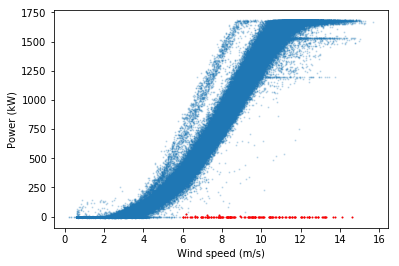

In [70]:
out_of_window = filters.window_range_flag(windspeed, 6., 40, power_kw, 20., 2000.)
plot_flagged_pc(windspeed, power_kw, out_of_window, 0.2)

In [71]:
windspeed = windspeed[~out_of_window]
power_kw = power_kw[~out_of_window]

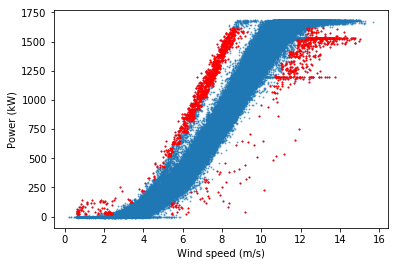

In [90]:
max_bin = .96*power_kw.max()
bin_outliers = filters.bin_filter(power_kw, windspeed, 100, 1.5, 'mean', 20., max_bin, 'scalar', 'all')
plot_flagged_pc(windspeed, power_kw, bin_outliers, 0.5)


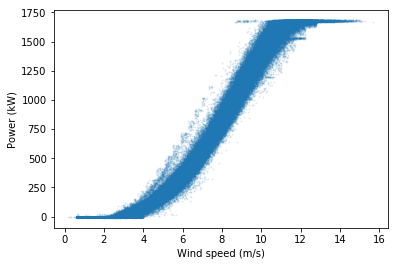

In [65]:
out_of_window = filters.window_range_flag(windspeed, 4., 8., power_kw, 0., 1250.)
windspeed = windspeed[(~out_of_window) & (~bin_outliers)]
power_kw = power_kw[(~out_of_window) & (~bin_outliers)]
plot_flagged_pc(windspeed, power_kw, np.repeat('True', len(windspeed)), 0.1)

In [51]:
# frozen event
frozen = filters.unresponsive_flag(windspeed, 3)
windspeed[frozen].head()
windspeed = windspeed[~frozen]
power_kw = power_kw[~frozen]

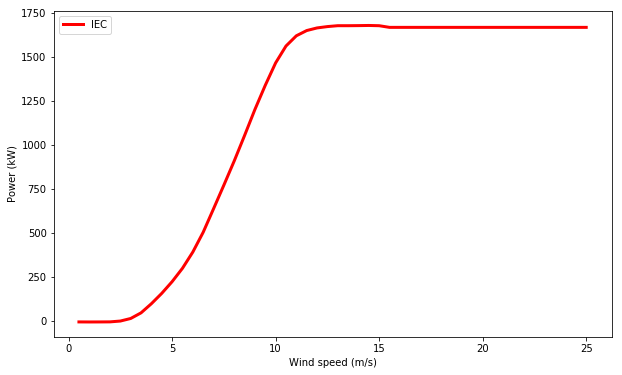

In [31]:
iec_curve = power_curve.IEC(windspeed, power_kw)
plt.figure(figsize = (10,6))
#plt.scatter(windspeed, power_kw, alpha=0.1, s = 1, c = 'gray')
x = np.linspace(0.5 , 25 )
plt.plot(x, iec_curve(x), color="red", label = 'IEC', linewidth = 3)

plt.xlabel('Wind speed (m/s)')
plt.ylabel('Power (kW)')
plt.legend()
plt.show()

### Power Curve Dictionary

In [17]:
import json

x = np.linspace(0.5 , 25 )
iec_power = np.around( iec_curve(x), decimals=2)
iec_power_curve = dict(zip(x, iec_power))
iec_power_curve = json.dumps(iec_power_curve)
print(iec_power_curve)

{"0.5": -4.3, "1.0": -4.57, "1.5": -4.53, "2.0": -4.29, "2.5": 0.4, "3.0": 16.46, "3.5": 49.96, "4.0": 98.88, "4.5": 151.67, "5.0": 216.22, "5.5": 296.99, "6.0": 390.39, "6.5": 493.63, "7.0": 609.36, "7.5": 732.94, "8.0": 856.74, "8.5": 983.57, "9.0": 1112.41, "9.5": 1243.36, "10.0": 1386.89, "10.5": 1497.41, "11.0": 1597.2, "11.5": 1638.24, "12.0": 1659.35, "12.5": 1670.76, "13.0": 1673.42, "13.5": 1674.19, "14.0": 1681.97, "14.5": 1681.98, "15.0": 1681.97, "15.5": 1681.93, "16.0": 1681.96, "16.5": 1682.01, "17.0": 1682.02, "17.5": 1682.07, "18.0": 1682.08, "18.5": 1682.06, "19.0": 1682.04, "19.5": 1682.07, "20.0": 1682.12, "20.5": 1682.03, "21.0": 1682.07, "21.5": 1682.36, "22.0": 1682.0, "22.5": 1682.09, "23.0": 1682.11, "23.5": 1682.02, "24.0": 1681.94, "24.5": 1681.91, "25.0": 1681.87}


In [40]:
"iec_power_curve": {
        "0.5": -2.08,
        "1.0": -1.23,
        "1.5": -3.61,
        "10.0": 1185.88,
        "10.5": 1307.6,
        "11.0": 1410.27,
        "11.5": 1479.13,
        "12.0": 1519.1,
        "12.5": 1539.11,
        "13.0": 1547.54,
        "13.5": 1551.64,
        "14.0": 1550.51,
        "14.5": 1546.52,
        "15.0": 1536.66,
        "15.5": 1518.38,
        "16.0": 1495.54,
        "16.5": 1484.48,
        "17.0": 1459.6,
        "17.5": 1451.5,
        "18.0": 1441.74,
        "18.5": 1426.08,
        "19.0": 1409.31,
        "19.5": 1385.57,
        "2.0": -3.98,
        "2.5": -3.72,
        "20.0": 1386.59,
        "20.5": 1339.17,
        "21.0": 1300.8,
        "21.5": 1242.8,
        "22.0": 1169.33,
        "22.5": 992.1,
        "23.0": 998.12,
        "23.5": 818.89,
        "24.0": 860.64,
        "24.5": 609.51,
        "25.0": 315.6,
        "3.0": 0.42,
        "3.5": 15.77,
        "4.0": 47.15,
        "4.5": 88.75,
        "5.0": 140.95,
        "5.5": 205.23,
        "6.0": 282.19,
        "6.5": 371.17,
        "7.0": 469.8,
        "7.5": 579.69,
        "8.0": 698.84,
        "8.5": 819.5,
        "9.0": 937.28,
        "9.5": 1060.54
    }

In [123]:
one_week[['TimeStamp','ProjectName','DeviceName', 'ActivePower', 'AmbientTemp']]

,TimeStamp,ProjectName,DeviceName,ActivePower,AmbientTemp
100563,2019-12-23 00:00:00,postrock,WTG005,1460.463745,11.095524
142624,2019-12-23 00:00:00,postrock,WTG006,1481.894897,13.135574
278224,2019-12-23 00:00:00,postrock,WTG001,1573.683838,13.444227
281359,2019-12-23 00:00:00,postrock,WTG008,1463.675537,11.960180
303633,2019-12-23 00:00:00,postrock,WTG007,1467.177002,13.241110
...,...,...,...,...,...
6923997,2019-12-29 23:50:00,postrock,WTG132,1287.580200,1.562450
6936606,2019-12-29 23:50:00,postrock,WTG134,1397.960571,0.960293
6957914,2019-12-29 23:50:00,postrock,WTG110,1573.181152,0.767316
7000500,2019-12-29 23:50:00,postrock,WTG127,1461.987671,8.314374
